In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import pickle

In [28]:
# Load data
df = pd.read_csv('seismic_gap_features.csv')

# Tampilkan info awal
pd.set_option('display.max_columns', None)
df.head()

,latitude,longitude,depth,mag,magType,rms,net,id,updated,place,type,status,magSource,year,month,day,mag_category,lat_bin,lon_bin,dekade,date
0,-1.453,119.664,33.0,4.6,mb,1.3,us,usp0001huf,2014-11-07T00:30:36.731Z,64 km SSW of Palu,Indonesia,4,us,1982,1,1,<6.0,-1.5,119.5,1980,1982-01-01
1,-3.207,130.307,40.2,4.7,mb,1.2,us,usp0001huh,2014-11-07T00:30:36.751Z,154 km E of Amahai,Indonesia,2,us,1982,1,2,<6.0,-3.5,130.0,1980,1982-01-02
2,3.261,99.171,188.8,4.2,mb,1.0,us,usp0001huv,2014-11-07T00:30:36.985Z,7 km S of Tebingtinggi,Indonesia,1,us,1982,1,2,<6.0,3.0,99.0,1980,1982-01-02
3,-3.530,139.537,33.0,3.7,mb,0.9,us,usp0001hv4,2014-11-07T00:30:37.118Z,159 km SW of Abepura,Indonesia,1,us,1982,1,3,<6.0,-4.0,139.5,1980,1982-01-03
4,-3.518,101.590,56.6,4.9,mb,0.9,us,usp0001hwt,2014-11-07T00:30:38.636Z,81 km WNW of Bengkulu,Indonesia,5,us,1982,1,6,<6.0,-4.0,101.5,1980,1982-01-06


In [29]:
# Mengurutkan data berdasarkan waktu (kolom 'date')
df = df.sort_values(by='date')

Jumlah sampel per cluster:
cluster
0    15144
1    25374
2    21324
Name: count, dtype: int64


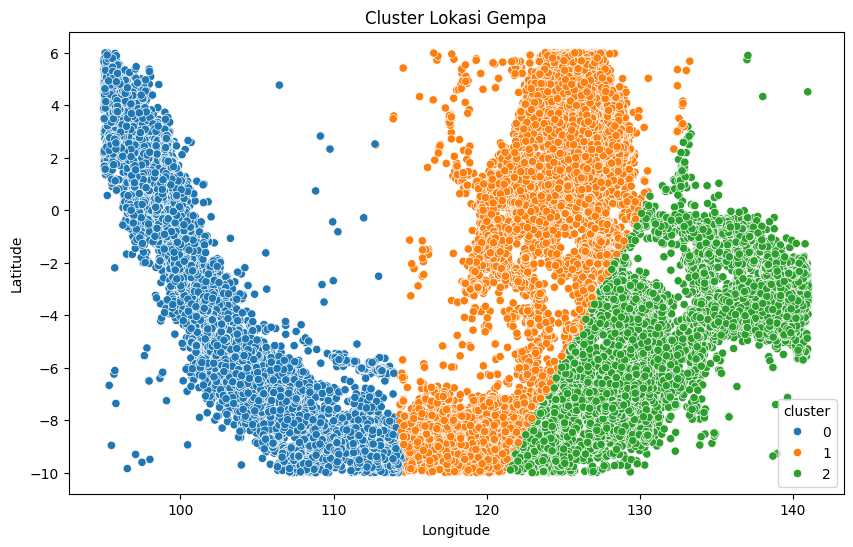

In [30]:
# Tentukan jumlah cluster
n_clusters = 3

# Pastikan kolom 'date' sudah dalam format datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 🔍 Filter: hanya gempa >= 4.0 Mw dan dari tahun 1982 sampai 2024
start_date = "1982-01-01"
end_date = "2024-12-31"
df = df[(df['mag'] >= 4.0) & (df['date'] >= start_date) & (df['date'] <= end_date)]


# Clustering berdasarkan koordinat
coords = df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(coords)

# Cek jumlah data per cluster
print("Jumlah sampel per cluster:")
print(df['cluster'].value_counts().sort_index())

# Visualisasi hasil cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='cluster', palette='tab10')
plt.title('Cluster Lokasi Gempa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [31]:
# Menambahkan fitur rolling dan lag untuk prediksi
df['mag_roll_mean_3'] = df['mag'].rolling(window=3).mean()
df['mag_lag_1'] = df['mag'].shift(1)
df['depth_lag_1'] = df['depth'].shift(1)
df = df.dropna()  # Menghapus baris dengan missing values setelah membuat rolling dan lag

# Tambahan sebelum split fitur-target
df['latitude_next'] = df['latitude'].shift(-1)
df['longitude_next'] = df['longitude'].shift(-1)
df = df.dropna(subset=['latitude_next', 'longitude_next'])  # Penting!

Model

In [32]:
#1. Model

# Pastikan kolom 'date' dalam format datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # 'coerce' untuk menangani nilai yang tidak valid

# Menghitung seismic gap (selisih waktu antar gempa)
df['gap'] = df['date'].diff().dt.days  # Menghitung selisih hari antar gempa

# Menghapus baris dengan missing values setelah membuat rolling dan lag, serta selisih waktu
df = df.dropna(subset=['gap'])

# Menghapus baris dengan missing values setelah membuat rolling dan lag
df = df.dropna()

# Menyimpan model, scaler, dan hasil training per cluster
cluster_models = {}
cluster_scalers = {}
cluster_histories = {}



[INFO] Training model untuk Cluster 0


C:\Users\fmoch\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 39.2002 - mae: 39.6233 - val_loss: 40.5814 - val_mae: 40.9812 - learning_rate: 0.0010
Epoch 2/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 37.9417 - mae: 38.3490 - val_loss: 38.4224 - val_mae: 38.8354 - learning_rate: 0.0010
Epoch 3/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 35.3590 - mae: 35.7665 - val_loss: 34.5571 - val_mae: 34.9711 - learning_rate: 0.0010
Epoch 4/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 31.4464 - mae: 31.8554 - val_loss: 29.6190 - val_mae: 30.0373 - learning_rate: 0.0010
Epoch 5/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 26.2252 - mae: 26.6327 - val_loss: 23.4486 - val_mae: 23.8660 - learning_rate: 0.0010
Epoch 6/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 19.9230 - mae: 20.3307 - val_loss: 16.2800 - val_mae: 16.6874 - learning_rate: 0.0010
Epoch 7/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.2396 - mae: 12.6464 - val_loss: 8.6501 - val_mae: 9.

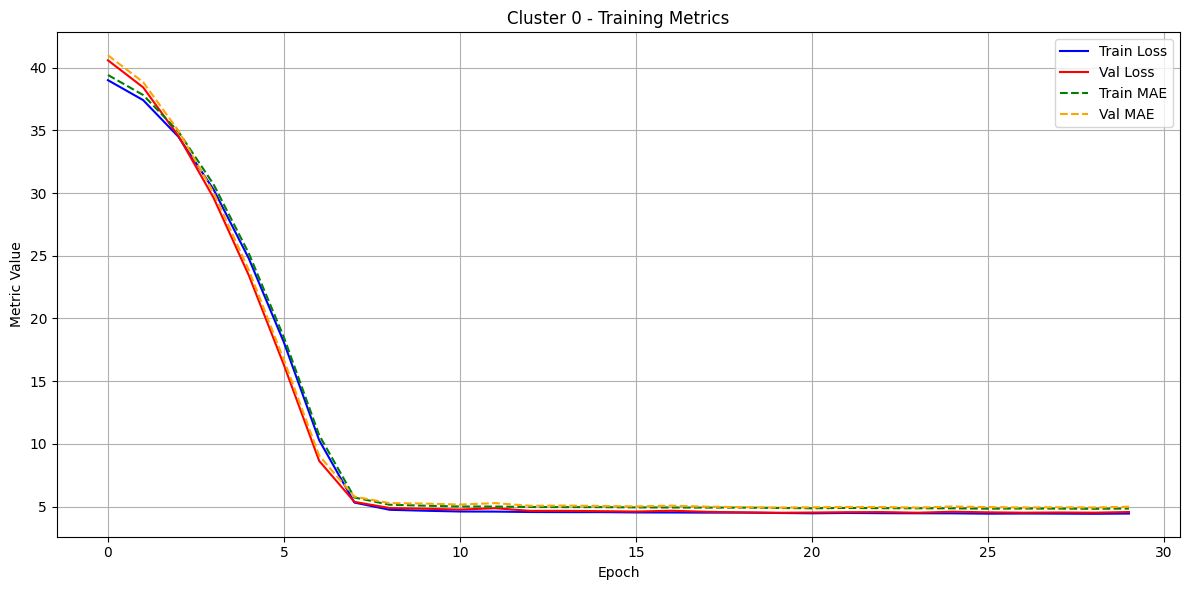


[INFO] Training model untuk Cluster 1


C:\Users\fmoch\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
265/265 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 41.5586 - mae: 41.9973 - val_loss: 39.8598 - val_mae: 40.2729 - learning_rate: 0.0010
Epoch 2/200
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 38.2791 - mae: 38.7040 - val_loss: 33.6454 - val_mae: 34.0634 - learning_rate: 0.0010
Epoch 3/200
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 31.2910 - mae: 31.7144 - val_loss: 24.1383 - val_mae: 24.5443 - learning_rate: 0.0010
Epoch 4/200
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 20.7917 - mae: 21.2127 - val_loss: 10.9468 - val_mae: 11.3571 - learning_rate: 0.0010
Epoch 5/200
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.2696 - mae: 8.6940 - val_loss: 3.5025 - val_mae: 3.9085 - learning_rate: 0.0010
Epoch 6/200
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.6835 - mae: 4.0967 - val_loss: 3.2809 - val_mae: 3.6757 - learning_rate: 0.0010
Epoch 7/200
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.6361 - mae: 4.0485 - val_loss: 3.2748 - val_mae: 3.6602 - lea

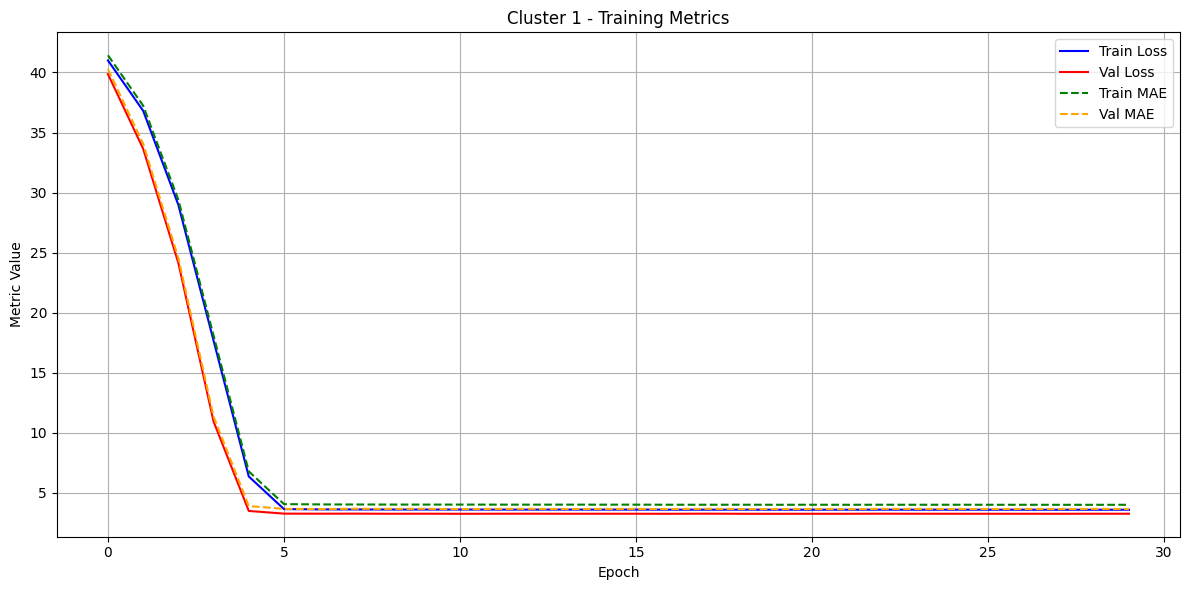


[INFO] Training model untuk Cluster 2


C:\Users\fmoch\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 42.0108 - mae: 42.4450 - val_loss: 40.6401 - val_mae: 41.0631 - learning_rate: 0.0010
Epoch 2/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 39.6468 - mae: 40.0737 - val_loss: 36.3270 - val_mae: 36.7452 - learning_rate: 0.0010
Epoch 3/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 34.8131 - mae: 35.2375 - val_loss: 29.2827 - val_mae: 29.6957 - learning_rate: 0.0010
Epoch 4/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 27.3487 - mae: 27.7715 - val_loss: 19.8215 - val_mae: 20.2394 - learning_rate: 0.0010
Epoch 5/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 17.5068 - mae: 17.9308 - val_loss: 9.1412 - val_mae: 9.5532 - learning_rate: 0.0010
Epoch 6/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.2074 - mae: 7.6304 - val_loss: 3.5654 - val_mae: 3.9721 - learning_rate: 0.0010
Epoch 7/200
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.7658 - mae: 4.1799 - val_loss: 3.4835 - val_mae: 3.8775 - l

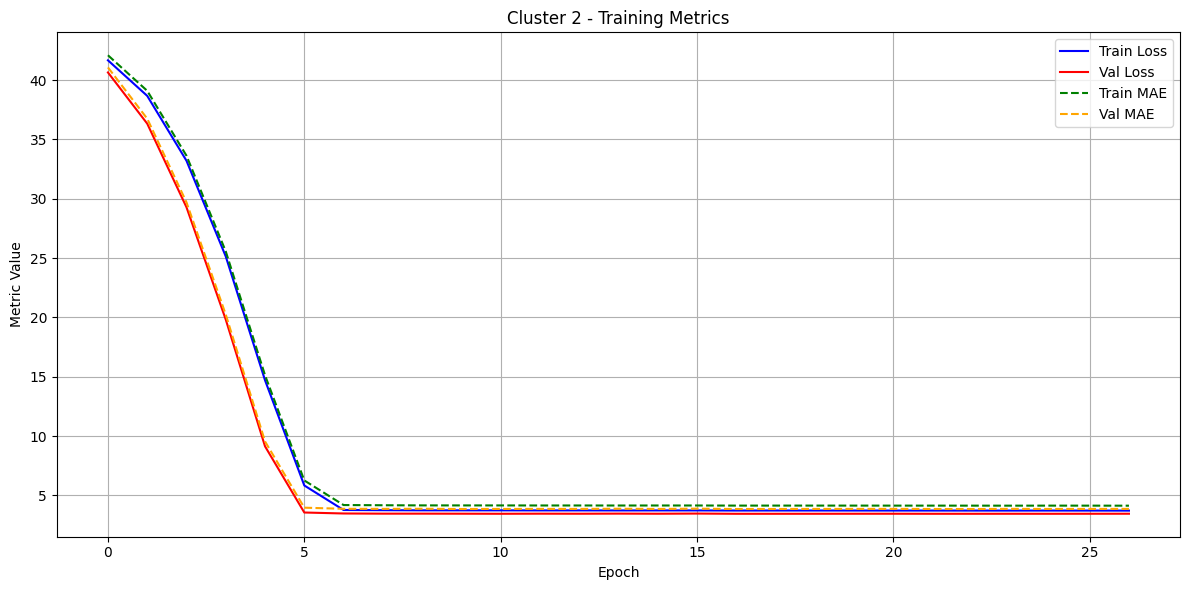

In [33]:
from tensorflow.keras.losses import Huber

# Training model per cluster
clusters = df['cluster'].unique()
for cluster in clusters:
    print(f"\n[INFO] Training model untuk Cluster {cluster}")
    
    df_cluster = df[df['cluster'] == cluster]
    X = df_cluster[['mag', 'depth', 'mag_roll_mean_3', 'mag_lag_1', 'depth_lag_1']]
    y = df_cluster[['gap', 'latitude_next', 'longitude_next']]

    scaler = RobustScaler() if cluster == 0 else StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Split data dengan TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        shuffle=False,
        random_state=42
    )

    # 🔁 Build Stacked LSTM model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='tanh',
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(LSTM(32, activation='tanh'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='linear'))

    # ⚙️ Compile
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=Huber(delta=1.0),  # Lebih stabil terhadap outlier
        metrics=['mae']
    )

    # 🔁 Callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # 🔧 Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # 🔒 Save per cluster
    cluster_models[cluster] = model
    cluster_scalers[cluster] = scaler
    cluster_histories[cluster] = history

    # 🎯 Evaluate
    y_pred = model.predict(X_test)
    gap_mae = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])
    lat_mae = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])
    lon_mae = mean_absolute_error(y_test.iloc[:, 2], y_pred[:, 2])

    print(f"[RESULT] Cluster {cluster}:")
    print(f"MAE Gap (hari): {gap_mae:.4f}")
    print(f"MAE Latitude: {lat_mae:.4f}")
    print(f"MAE Longitude: {lon_mae:.4f}")

    # 📊 Visualisasi
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='red')
    plt.plot(history.history['mae'], label='Train MAE', linestyle='--', color='green')
    plt.plot(history.history['val_mae'], label='Val MAE', linestyle='--', color='orange')
    plt.title(f"Cluster {cluster} - Training Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[INFO] Menampilkan visualisasi untuk Cluster 0
[INFO] Menampilkan visualisasi untuk Cluster 1
[INFO] Menampilkan visualisasi untuk Cluster 2


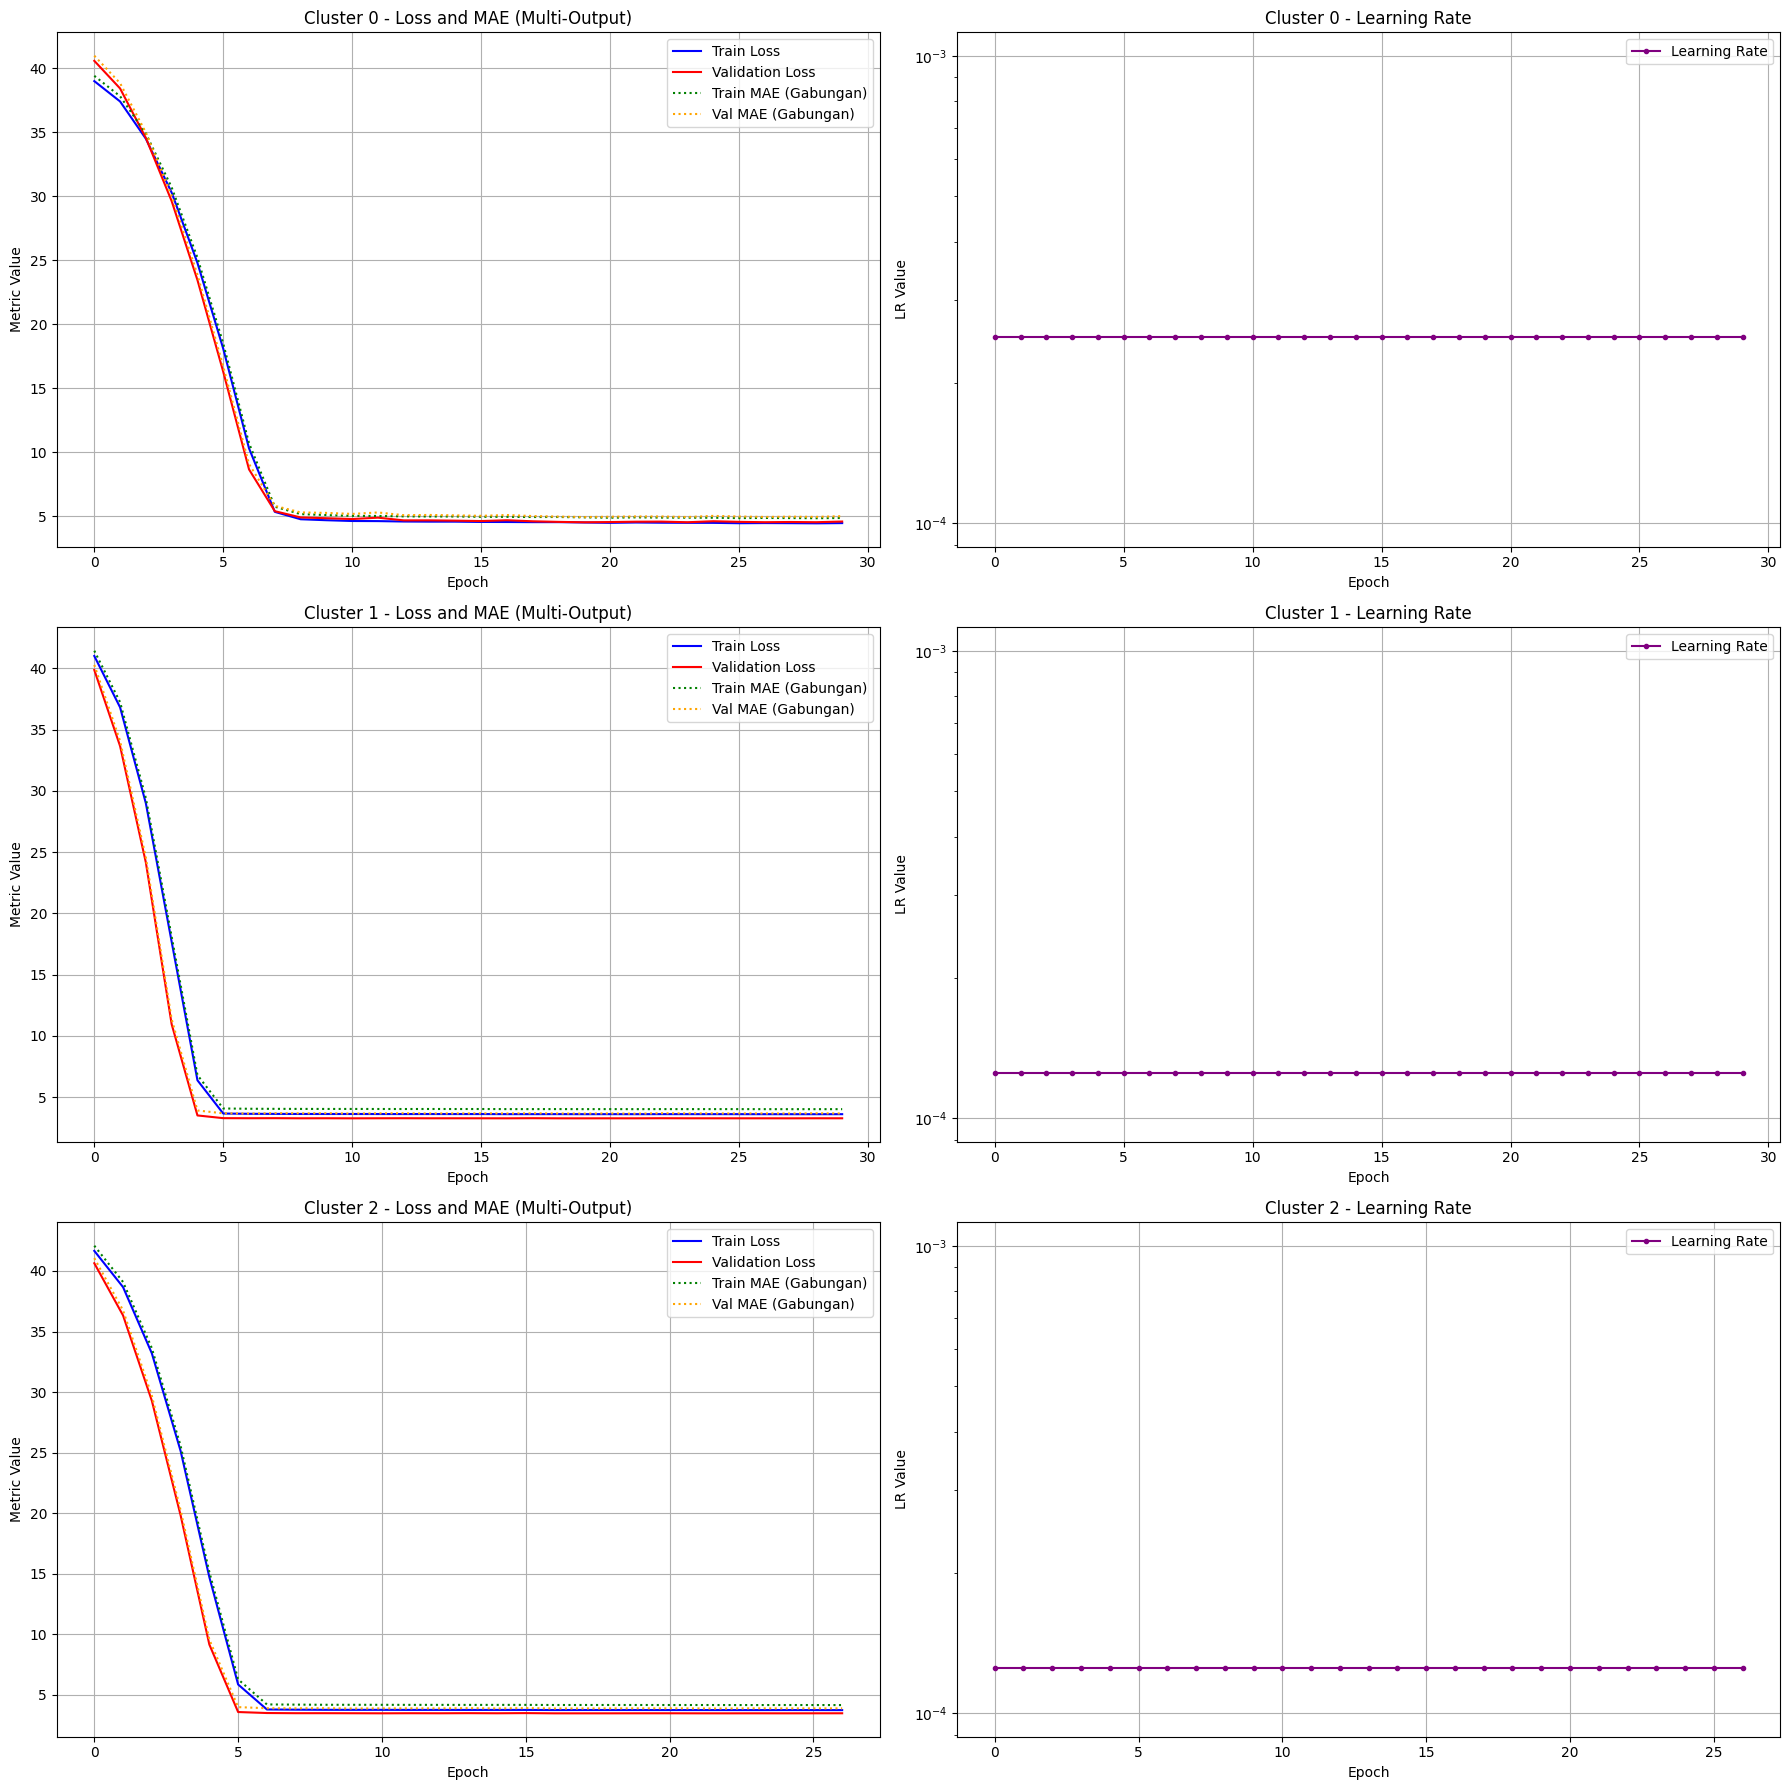

In [34]:
# Inisialisasi subplots untuk visualisasi
num_clusters = len(clusters)
fig, axes = plt.subplots(num_clusters, 2, figsize=(18, 6 * num_clusters))  # 2 kolom: loss/MAE dan LR

# Jika hanya ada satu cluster, pastikan axes tetap berbentuk array
if num_clusters == 1:
    axes = [axes]

# Iterasi untuk setiap cluster dan plot
for idx, cluster in enumerate(clusters):
    print(f"[INFO] Menampilkan visualisasi untuk Cluster {cluster}")
    
    # Ambil history training dari model per cluster
    history = cluster_histories[cluster]
    
    # --- Plot 1: Loss dan MAE (semua output) ---
    ax1 = axes[idx][0] if num_clusters > 1 else axes[0]
    
    # Plotting Loss
    ax1.plot(history.history['loss'], label='Train Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    
    # Plotting MAE jika tersedia
    if 'mae' in history.history:
        ax1.plot(history.history['mae'], label='Train MAE (Gabungan)', linestyle=':', color='green')
        ax1.plot(history.history['val_mae'], label='Val MAE (Gabungan)', linestyle=':', color='orange')
    
    # Tambahkan judul dan label
    ax1.set_title(f"Cluster {cluster} - Loss and MAE (Multi-Output)")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Metric Value')
    ax1.legend()
    ax1.grid(True)
    
    # --- Plot 2: Learning Rate ---
    ax2 = axes[idx][1] if num_clusters > 1 else axes[1]
    
    # Ekstrak LR dari optimizer atau fallback
    if 'lr' in history.history:
        lr_history = history.history['lr']
    else:
        lr_history = [history.model.optimizer.learning_rate.numpy()] * len(history.epoch)
    
    ax2.plot(lr_history, label='Learning Rate', color='purple', marker='o', markersize=3)
    ax2.set_title(f"Cluster {cluster} - Learning Rate")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('LR Value')
    ax2.legend()
    ax2.grid(True)
    ax2.set_yscale('log')

# Menyesuaikan layout
plt.tight_layout()
plt.show()

In [35]:
results = []
for cluster in clusters:
    model = cluster_models[cluster]
    history = cluster_histories[cluster]
    y_pred = model.predict(X_test)

    gap_mae = mean_absolute_error(y_test['gap'], y_pred[:, 0])
    lat_mae = mean_absolute_error(y_test['latitude_next'], y_pred[:, 1])
    lon_mae = mean_absolute_error(y_test['longitude_next'], y_pred[:, 2])
    
    results.append([cluster, gap_mae, lat_mae, lon_mae])

results_df = pd.DataFrame(results, columns=['Cluster', 'MAE_Gap', 'MAE_Lat', 'MAE_Lon'])
print(results_df)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
   Cluster   MAE_Gap   MAE_Lat    MAE_Lon
0        0  0.290458  4.083245  12.208877
1        1  0.326988  4.227485   7.168097
2        2  0.354602  4.011556   7.130809


In [36]:
# import os

# # Buat folder jika belum ada
# os.makedirs('saved_models uji ke 5', exist_ok=True)
# os.makedirs('saved_scalers uji ke 5', exist_ok=True)

# for cluster in cluster_models:
#     # Simpan model dalam format .keras (direkomendasikan)
#     model_path = f"saved_models uji ke 5/lstm_cluster_{cluster}.keras"
#     cluster_models[cluster].save(model_path)  # Tidak perlu mengatur format, otomatis .keras

#     # Simpan scaler dengan pickle
#     scaler_path = f"saved_scalers uji ke 5/scaler_cluster_{cluster}.pkl"
#     with open(scaler_path, 'wb') as f:
#         pickle.dump(cluster_scalers[cluster], f)

#     print(f"[SAVED] Cluster {cluster} model (.keras) dan scaler disimpan.")


uji Akurasi

In [38]:
# Asumsikan df sudah ada dan sudah dikluster, serta fitur dan target sudah dibuat
cluster_X_test = {}
cluster_y_test = {}

for cluster in range(3):  # Ganti jika jumlah cluster berbeda
    df_cluster = df[df['cluster'] == cluster]
    
    X = df_cluster[['mag', 'depth', 'mag_roll_mean_3', 'mag_lag_1', 'depth_lag_1']]
    y = df_cluster['gap']

    scaler = cluster_scalers[cluster]
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
    
    # TimeSeriesSplit terakhir yang digunakan di training
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    cluster_X_test[cluster] = X_test
    cluster_y_test[cluster] = y_test


In [40]:
y_preds = {}
y_tests = {}

for cluster in range(3):
    model = cluster_models[cluster]
    X_test_cluster = cluster_X_test[cluster]
    y_test_cluster = cluster_y_test[cluster]
    
    y_pred = model.predict(X_test_cluster)
    
    y_preds[cluster] = y_pred
    y_tests[cluster] = y_test_cluster
    
    print(f"Cluster {cluster}:")
    print(f"Sample predictions: {y_preds[cluster][:5]}")  # Menampilkan beberapa prediksi pertama
    print(f"True values: {y_tests[cluster].iloc[:5].values}")  # Menampilkan nilai asli
    
    
    
    


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Cluster 0:
Sample predictions: [[ 3.72566760e-01 -2.25037575e+00  1.26199615e+02]
 [ 3.00894737e-01 -2.43328476e+00  1.25005219e+02]
 [ 8.06815773e-02 -2.62032080e+00  1.26803741e+02]
 [ 3.47449958e-01 -2.37165236e+00  1.26507126e+02]
 [ 3.25327337e-01 -2.44970679e+00  1.25305916e+02]]
True values: [0. 0. 0. 1. 0.]
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Cluster 1:
Sample predictions: [[  0.25660253  -2.4130971  126.106384  ]
 [  0.15660891  -1.0490584  126.08121   ]
 [  0.23766331  -0.66029847 126.414345  ]
 [  0.25361466  -2.7990253  125.48066   ]
 [  0.19942325  -2.071028   126.328285  ]]
True values: [0. 0. 0. 0. 0.]
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Cluster 2:
Sample predictions: [[  0.35967052  -2.8786268  126.308945  ]
 [  0.3384546   -3.4007375  126.13256   ]
 [  0.23530945  -2.7449126  126.078804  ]
 [  0.20475847  -2.7240427  127.57053   ]
 [  0.19203855  -2.685809   127.77058   ]]
True values: [0. 0. 1. 0. 1.]


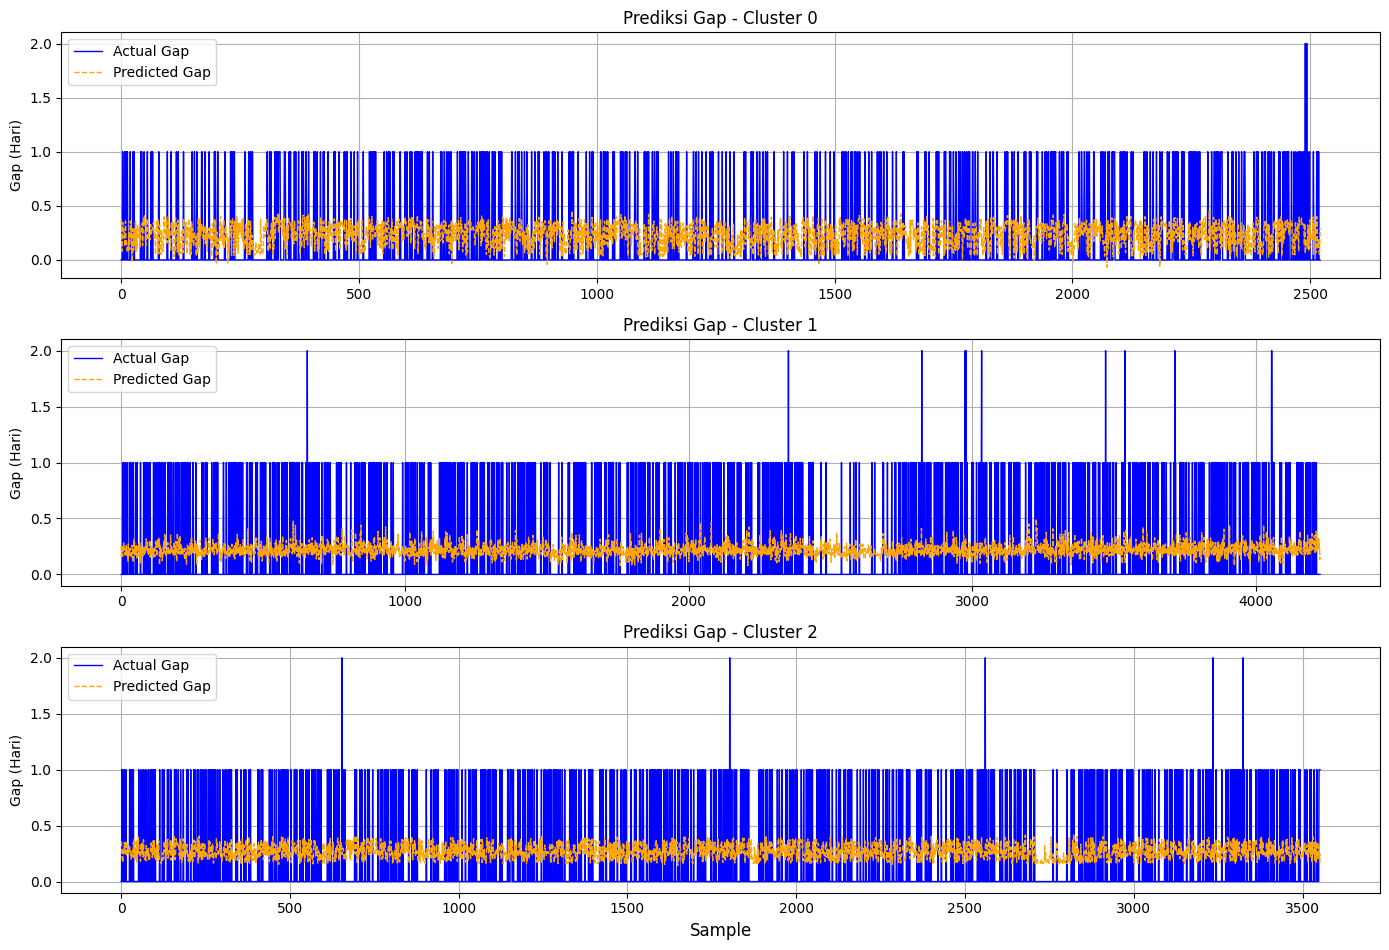

In [41]:
# === Visualisasi Prediksi vs Aktual Gap per Cluster ===
# Jumlah cluster
num_clusters = len(y_tests)

# Buat 5 subplot vertikal
fig, axes = plt.subplots(num_clusters, 1, figsize=(14, 3.2 * num_clusters), sharex=False)

for cluster in range(num_clusters):
    y_test = y_tests[cluster]
    y_pred = y_preds[cluster]

    ax = axes[cluster]
    ax.plot(y_test.values, label='Actual Gap', color='blue', linewidth=1)
    ax.plot(y_pred[:, 0], label='Predicted Gap', color='orange', linestyle='--', linewidth=1)
    ax.set_title(f"Prediksi Gap - Cluster {cluster}", fontsize=12)
    ax.set_ylabel("Gap (Hari)")
    ax.legend()
    ax.grid(True)

# Label sumbu X global
plt.xlabel("Sample", fontsize=12)
plt.tight_layout()
plt.show()

In [42]:
# === Prediksi Gempa Berikutnya per Cluster ===
print("\n📍 Prediksi Gempa Berikutnya per Cluster")
for cluster in clusters:
    last_input = df[df['cluster'] == cluster].iloc[-1][['mag', 'depth', 'mag_roll_mean_3', 'mag_lag_1', 'depth_lag_1']].values.reshape(1, -1)
    scaled_input = cluster_scalers[cluster].transform(last_input).reshape(1, 1, -1)
    prediction = cluster_models[cluster].predict(scaled_input)

    print(f"\n🔹 Cluster {cluster}")
    print(f"  Prediksi Gap (hari): {prediction[0][0]:.2f}")
    print(f"  Prediksi Lokasi    : Latitude = {prediction[0][1]:.2f}, Longitude = {prediction[0][2]:.2f}")



📍 Prediksi Gempa Berikutnya per Cluster
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

🔹 Cluster 0
  Prediksi Gap (hari): 0.30
  Prediksi Lokasi    : Latitude = -2.45, Longitude = 124.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\fmoch\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\fmoch\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\fmoch\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔹 Cluster 1
  Prediksi Gap (hari): 0.18
  Prediksi Lokasi    : Latitude = -2.17, Longitude = 126.30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🔹 Cluster 2
  Prediksi Gap (hari): 0.25
  Prediksi Lokasi    : Latitude = -2.49, Longitude = 126.10
